In [1]:
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import json
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['image.cmap'] = 'jet'

import sys
sys.path.extend(['../'])
from data_gen.gen_joint_data import *
from data_gen.rotation import *
import c3d
from scipy.io import loadmat

In [3]:
'''
function to apply moving average on n dim data along first axis

Args:
    a: numpy array, data to smooth
    n: int, window length for smoothing
Returns:
    data: numpy array; data with smoothing
'''
def moving_average(a, n=3) :
    ret = np.cumsum(a, axis=0, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


'''
Function to preprocess data from microsoft kinect azure
to generate spectrograms from virtual radar

Args:
    filename: str, file name of json data
    pad_frames: int, number of interpolated frames to insert 
                between real frames
Returns:
    data: numpy array; shape-(num_frames, num_joints, 3), joint position data
    edges: list of tuples, tuple shape-(4), vertices in edge, dia of part, length of part (modeled as ellipsoid)   
    total_time: float, total time of data sample in secs
'''
def preprocess_azure_kinect(filename, pad_frames=1, window_len=15):
    # define edges of the skeleton graph
    edges = [(1, 0, 0.3), (2, 1, 0.3), (3, 2, 0.1), (4, 2, 0.1), 
             (5, 4, 0.1), (6, 5, 0.1), (7, 6, 0.1), (8, 7, 0.05), 
             (9, 8, 0.05), (10, 7, 0.05), (11, 2, 0.1), (12, 11, 0.1), 
             (13, 12, 0.1), (14, 13, 0.1), (15, 14, 0.05), (16, 15, 0.05), 
             (17, 14, 0.05), (18, 0, 0.1), (19, 18, 0.15), (20, 19, 0.12), 
             (21, 20, 0.1), (22, 0, 0.1), (23, 22, 0.15), 
             (24, 23, 0.12), (25, 24, 0.1), (26, 3, 0.1)]

    # read json file
    with open(filename) as f:
        json_file = json.load(f)

    # gather joint positions and timestamps of all joints
    data = []
    for frame in json_file['frames']:
        if frame['num_bodies'] > 0:
            data.append(frame['bodies'][0]['joint_positions'])
    data = np.array(data)[:, :27] #discard eyes, nose and ears
    
    T, V, C = data.shape
    data = data * 0.001 # convert data from meters to mm
    data = data.reshape(-1, V*C)
    num_frames = T-window_len+1

    # linear interpolation to fill in the extra/pad frames
    data_smooth = np.zeros((pad_frames*num_frames, V*C))
    for i in range(V*C):
        tmp = moving_average(data[:, i], window_len)
        tmp = np.interp(np.arange(0, pad_frames*num_frames), 
                        np.arange(0, pad_frames*num_frames, pad_frames),
                        tmp)
        data_smooth[:, i] = tmp
    data = np.reshape(data_smooth, [-1, V, C])

    return data, edges


def preprocess_ntu(filename, pad_frames=1, window_len=15):
    edges = [(0, 1, 0.3), (1, 20, 0.3), (20, 2, 0.3), (2, 3, 0.1),
            (20, 4, 0.1), (4, 5, 0.1), (5, 6, 0.1), (6, 7, 0.1),
            (7, 21, 0.05), (7, 22, 0.05), (20, 8, 0.1), (8, 9, 0.1),
            (9, 10, 0.1), (10, 11, 0.1), (11, 23, 0.05), (11, 24, 0.05),
            (0, 16, 0.1), (0, 12, 0.1), (12, 13, 0.15), (13, 14, 0.12),
            (14, 15, 0.1), (16, 17, 0.15), (17, 18, 0.12), (18, 19, 0.1)]
    
    data = read_xyz(filename, max_body_kinect, num_joint)
    data = np.transpose(data, (3, 1, 2, 0))

    # denoise data with moving average
    N, T, V, C = data.shape
    data = data.reshape(N, T, V*C)
    num_frames = T-window_len+1

    # linear interpolation to fill in the extra/pad frames
    data_smooth = np.zeros((N, pad_frames*num_frames, V*C))
    for j in range(N):
        for i in range(V*C):
            tmp = moving_average(data[j, :, i], window_len)
            tmp = np.interp(np.arange(0, pad_frames*num_frames),
                            np.arange(0, pad_frames*num_frames, pad_frames),
                            tmp)
            data_smooth[j, :, i] = tmp
    data = np.reshape(data_smooth, [N, -1, V, C])
    
    return data, edges

In [4]:
'''
Calculates the backscattered RCS of an ellipsoid
with semi-axis lengths of a, b, and c.
The source code is based on Radar Systems Analysis and Design Using
MATLAB, By B. Mahafza, Chapman & Hall/CRC 2000.

Args:
    a: float, file name of json data
    b: float, file name of json data
    c: float, file name of json data
    phi: numpy array; shape-(num_frames,), phase of part for each frame
    theta: numpy array; shape-(num_frames,), angle of part for each frame

Returns:
    rcs: numpy array; shape-(num_frames,), radar backscatter of part 
'''
def rcsellipsoid(a,b,c,phi,theta):
    a = np.square(a)
    b = np.square(b)
    c = np.square(c)
    rcs = (np.pi*a*b*c)/ \
            (a*(np.sin(theta)**2)*(np.cos(phi)**2) + \
             b*(np.sin(theta)**2)*(np.sin(phi)**2) + \
             c*(np.cos(theta)**2))**2
    return rcs

In [5]:
'''
Calculates the backscattered RCS of a skeleton sequence

Args:
    joint1: numpy array; shape-(num_frames, 3), joint to calc backscattes
    joint2: numpy array; shape-(num_frames, 3), joint that belongs to part of interest
    edges: list of tuples, tuple shape-(4), vertices in edge, dia of part, length of
           part (modeled as ellipsoid)
    radar_loc: list, shape-(3), radar location
    radar_lambda: float, radar wavelength
    rangeres: float, range resolution

Returns:
    TF; numpy array; shape-(512, 283), spectrogram
'''

def synthetic_spectrogram_ntu(filename,
                              radar_lambda=0.02,
                              pad_frames=15,
                              window_len=15,
                              rangeres=0.01,
                              radar_loc=[0,0,0]):
    joint_data, edges = preprocess_ntu(filename, 
                                       pad_frames=pad_frames, 
                                       window_len=window_len)
    src, dst, part_dia = map(list, zip(*edges))
    data = np.zeros((600, max_frame*pad_frames), dtype=np.complex64)
    for person in joint_data:
        if person.sum() == 0:
            continue

        joint1 = person[:, src]
        joint2 = person[:, dst]
        radar_dist = np.abs(joint1-radar_loc)
        distances = np.linalg.norm(radar_dist, axis=-1)
        A = radar_loc-((joint1+joint2)/2)
        B = joint2-joint1
        A_dot_B = (A*B).sum(axis=-1)
        A_sum_sqrt = np.linalg.norm(A, axis=-1)
        B_sum_sqrt = np.linalg.norm(B, axis=-1)
        ThetaAngle = np.arccos(A_dot_B / ((A_sum_sqrt * B_sum_sqrt)+1e-6))
        PhiAngle = np.arcsin((radar_loc[1]-joint1[:, :, 1])/ \
                            (np.linalg.norm(radar_dist[:, :, :2], axis=-1)+1e-6))

        rcs = rcsellipsoid(part_dia,
                           part_dia,
                           np.linalg.norm(joint1-joint2, axis=-1).mean(axis=0),
                           PhiAngle,
                           ThetaAngle)
        amp = np.sqrt(rcs)
        phase = amp*np.exp(-1j*4*np.pi*distances/radar_lambda)
        indices = np.floor(distances/rangeres).astype(int)-1

        for i in range(joint1.shape[1]):
            data[indices[:, i], np.arange(joint1.shape[0])] += phase[:, i]

    range_map = np.flip(20*np.log10(np.abs(data)+1e-6), axis=0)
    data = np.sum(data, axis=0)

    _, _, TF = signal.stft(data,
                           window=signal.gaussian(224, std=16),
                           nperseg=224,
                           noverlap=224-20,
                           nfft=224,
                           return_onesided=False)

    TF = np.fft.fftshift(TF, 0)
    TF = 20*np.log10(np.abs(TF)+1e-6)
    return TF, range_map


In [139]:
'''
Calculates the backscattered RCS of a skeleton sequence

Args:
    joint_data: numpy array; shape-(num_frames, num_joints, 3), joints to calc backscattered RCS
    edges: list, shape-(num_edges), diameter of each part (modeled as ellipsoid)   
    radar_loc: list, shape-(3), radar location
    radar_lambda: float, radar wavelength
    rangeres: float, range resolution
    num_range_bins: int: number of range bins
    num_frames: int, number of time frames
Returns:
    data; numpy array; shape-(num_range_bins, num_frames), backscattered RCS
'''
def synthetic_spectrogram(joint_data, edges, 
                          radar_lambda=0.02,
                          rangeres=0.01, 
                          radar_loc=[0,0,0]):    
    src, dst, part_dia = map(list, zip(*edges))
    
    joint1 = joint_data[:, src]
    joint2 = joint_data[:, dst]
    radar_dist = np.abs(joint1-radar_loc)
    distances = np.linalg.norm(radar_dist, axis=-1)
    A = radar_loc-((joint1+joint2)/2)
    B = joint2-joint1
    A_dot_B = (A*B).sum(axis=-1)
    A_sum_sqrt = np.linalg.norm(A, axis=-1)
    B_sum_sqrt = np.linalg.norm(B, axis=-1)
    ThetaAngle = np.arccos(A_dot_B / (A_sum_sqrt * B_sum_sqrt))
    PhiAngle = np.arcsin((radar_loc[1]-joint1[:, :, 1])/np.linalg.norm(radar_dist[:, :, :2], axis=-1))
    
    rcs = rcsellipsoid(part_dia, 
                       part_dia, 
                       np.linalg.norm(joint1-joint2, axis=-1).mean(axis=0), 
                       PhiAngle, 
                       ThetaAngle)
    amp = np.sqrt(rcs) 
    phase = amp*np.exp(-1j*4*np.pi*distances/radar_lambda)
    indices = np.floor(distances/rangeres).astype(int)-1

    data = np.zeros((np.max(indices)+1, joint1.shape[0]), dtype=np.complex64)
    for i in range(joint1.shape[1]):
        data[indices[:, i], np.arange(joint1.shape[0])] += phase[:, i]   
        
    range_map = np.flip(20*np.log10(np.abs(data)+1e-6), axis=0)
    data = np.sum(data, axis=0)

    _, _, TF = signal.stft(data, 
                           window=signal.gaussian(512, std=16),
                           nperseg=512,
                           noverlap=512-16,
                           nfft=512,
                           return_onesided=False)
    TF = np.fft.fftshift(np.abs(TF), 0)
    TF = np.flip(TF, axis=1)
    TF = 20*np.log10(TF+1e-6)
    return TF, range_map

(512, 441)


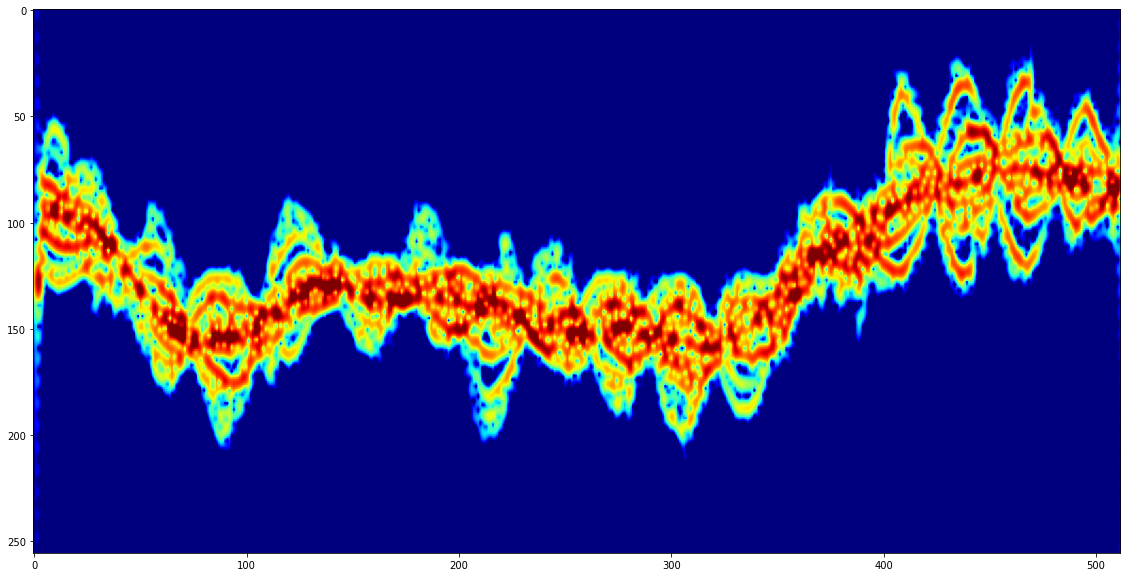

In [184]:
data, edges = preprocess_azure_kinect("/home/kjakkala/GCN/data_gen/sim_data.json", 25)
spectrogram, _ = synthetic_spectrogram(data, edges, 
                                       radar_lambda=0.02,
                                       rangeres=0.001, 
                                       radar_loc=[0,0,0])

print(spectrogram.shape)
im = plt.imshow(resize(spectrogram, (256, 512))) 
im.set_clim(-35, 0)
plt.show()

(224, 751)


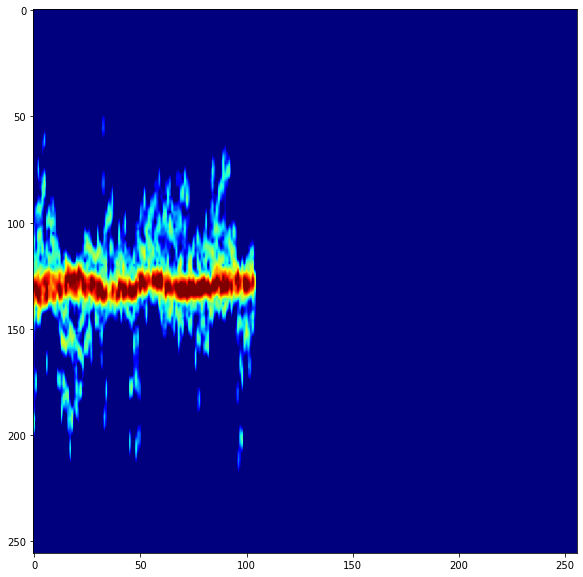

In [208]:
fname = '/home/kjakkala/GCN/data/nturgbd_raw/nturgb+d_skeletons/S009C003P025R001A030.skeleton'
spectrogram = synthetic_spectrogram_ntu(fname,
                                        window_len=15,
                                        radar_lambda=0.0009,
                                        pad_frames=50)
 
print(spectrogram[0].shape)
im = plt.imshow(resize(spectrogram[0], (256, 256))) 
im.set_clim(-35, 0)
plt.show()

(512, 513)


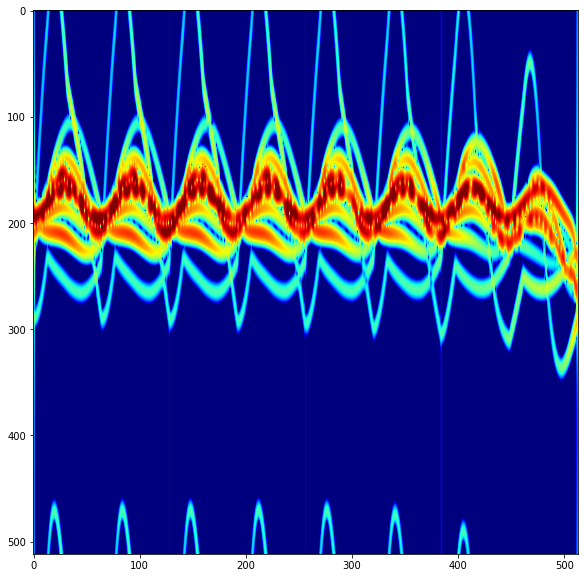

In [186]:
file = loadmat("sim_data.mat")['segment'][0]
data = []
for i in range(17):
    data.append(file[i][1])
data = np.array(data).transpose(2, 0, 1)
edges = [(0, 1, 0.3), (1, 2, 0.1),
         (1, 3, 0.1), (3, 5, 0.1), (5, 7, 0.1), 
         (1, 4, 0.1), (4, 6, 0.1), (6, 8, 0.1),
         (0, 9, 0.1), (9, 11, 0.1), (11, 13, 0.1), (13, 15, 0.1),
         (0, 10, 0.1), (10, 12, 0.1), (12, 14, 0.1), (14, 16, 0.1)]

spectrogram, _ = synthetic_spectrogram(data, edges, 
                                       radar_lambda=0.009,
                                       rangeres=0.01, 
                                       radar_loc=[0,0,0])

print(spectrogram.shape)
im = plt.imshow(spectrogram) 
im.set_clim(-45, 5)

plt.show()

(512, 2058)


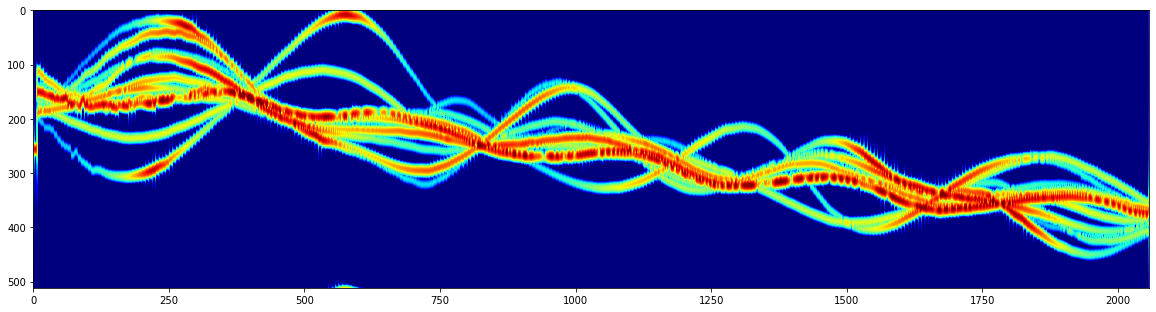

In [199]:
window_len = 15
pad_frames = 100

reader = c3d.Reader(open('02_01.c3d', 'rb'))
scale_xyz = np.abs(reader.point_scale)*0.0254

data = []
for i, points, analog in reader.read_frames():
    data.append(points*scale_xyz)
data = np.array(data)[:, :, :3]
T, V, C = data.shape
data = data.reshape(-1, V*C)
num_frames = T-window_len+1

# linear interpolation to fill in the extra/pad frames
data_smooth = np.zeros((pad_frames*num_frames, V*C))
for i in range(V*C):
    tmp = moving_average(data[:, i], window_len)
    tmp = np.interp(np.arange(0, pad_frames*num_frames), 
                    np.arange(0, pad_frames*num_frames, pad_frames),
                    tmp)
    data_smooth[:, i] = tmp
data = np.reshape(data_smooth, [-1, V, C])
edges = [(0, 1, 0.3), (1, 2, 0.1),
         (1, 3, 0.1), (3, 5, 0.1), (5, 7, 0.1), 
         (1, 4, 0.1), (4, 6, 0.1), (6, 8, 0.1),
         (0, 9, 0.1), (9, 11, 0.1), (11, 13, 0.1), (13, 15, 0.1),
         (0, 10, 0.1), (10, 12, 0.1), (12, 14, 0.1), (14, 16, 0.1)]

spectrogram, _ = synthetic_spectrogram(data, edges, 
                                       radar_lambda=0.001,
                                       rangeres=0.001, 
                                       radar_loc=[0,0,0])

print(spectrogram.shape)
im = plt.imshow(spectrogram) 
im.set_clim(-45, 5)
plt.show()